In [ ]:
# STEP 1: Mount Google Drive and inspect dataset structure
from google.colab import drive
import os
import pandas as pd
from pathlib import Path
from PIL import Image

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define your dataset path (adjust if needed)
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/Xray_TB/datasets/Cleaned Data"  # update if your folder is different
normal_path = Path(DATASET_PATH) / "Normal"
tb_path = Path(DATASET_PATH) / "Tuberculosis"

print("Normal images:", len(list(normal_path.glob("*"))))
print("TB images:", len(list(tb_path.glob("*"))))

# 3. Collect basic info about files (size, dimensions, etc.)
records = []
for label, folder in [("Normal", normal_path), ("TB", tb_path)]:
    for f in folder.glob("*"):
        try:
            img = Image.open(f)
            records.append({
                "filename": f.name,
                "label": label,
                "width": img.width,
                "height": img.height,
                "mode": img.mode,
                "size_bytes": os.path.getsize(f)
            })
        except Exception as e:
            print("Error reading", f, e)

df = pd.DataFrame(records)
print(df.head())

# 4. Save inventory for reproducibility
output_dir = "/content/drive/MyDrive/TB_Project"
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist
df.to_csv(os.path.join(output_dir, "inventory.csv"), index=False)

print("✅ Inventory saved at TB_Project/inventory.csv")
print("Summary:\n", df.groupby("label")[["width","height","size_bytes"]].describe())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Normal images: 3393
TB images: 2660
          filename   label  width  height mode  size_bytes
0   Normal-322.png  Normal    512     512  RGB      164680
1   Normal-332.png  Normal    512     512  RGB      149669
2  Normal-3285.png  Normal    512     512  RGB      174669
3  Normal-3320.png  Normal    512     512  RGB      158785
4  Normal-3204.png  Normal    512     512  RGB      172055
✅ Inventory saved at TB_Project/inventory.csv
Summary:
          width                                                 height         \
         count   mean  std    min    25%    50%    75%    max   count   mean   
label                                                                          
Normal  3393.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0  3393.0  512.0   
TB      2660.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0  2660.0  512.0   

        ...             

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

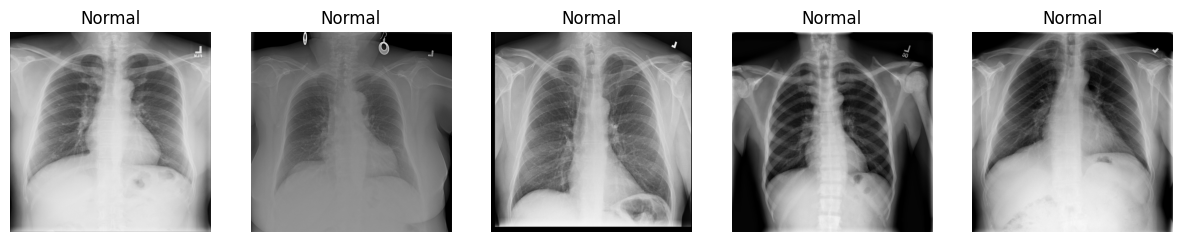

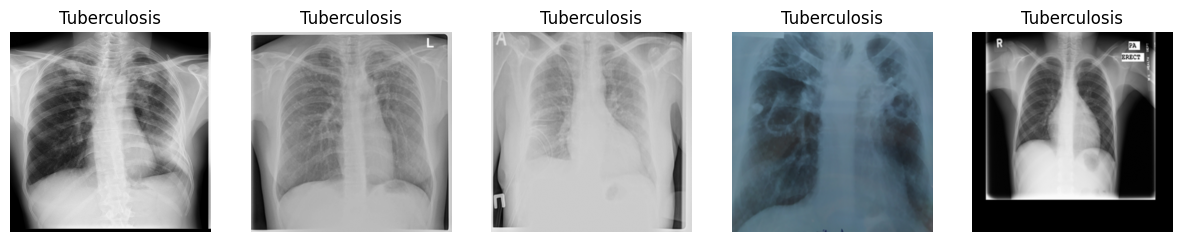

In [ ]:
# STEP 2: Visual Audit - Display random samples from both classes
import matplotlib.pyplot as plt
import random

def show_samples(folder, label, n=5):
    files = list(Path(folder).glob("*"))
    sample_files = random.sample(files, min(n, len(files)))

    plt.figure(figsize=(15, 3))
    for i, f in enumerate(sample_files):
        img = Image.open(f)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis("off")
    plt.show()

# Show 5 samples from Normal and TB
show_samples(normal_path, "Normal", n=5)
show_samples(tb_path, "Tuberculosis", n=5)


In [ ]:
# STEP 3: Split dataset into Train / Val / Test sets
import shutil
from sklearn.model_selection import train_test_split

# Define target split ratios
train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

# Destination root
BASE_DIR = "/content/drive/MyDrive/TB_Project/split_dataset"
os.makedirs(BASE_DIR, exist_ok=True)

# Clean if already exists (avoid duplicates)
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)
    os.makedirs(BASE_DIR)

# Helper to split one class
def split_and_copy(src_dir, class_name):
    files = list(Path(src_dir).glob("*"))
    labels = [class_name] * len(files)

    # First split: train vs temp
    X_train, X_temp, _, y_temp = train_test_split(
        files, labels, train_size=train_ratio, stratify=labels, random_state=42
    )
    # Second split: validation vs test
    X_val, X_test = train_test_split(
        X_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    # Define destinations
    for split_name, split_files in zip(["train", "val", "test"], [X_train, X_val, X_test]):
        split_dir = Path(BASE_DIR) / split_name / class_name
        split_dir.mkdir(parents=True, exist_ok=True)
        for f in split_files:
            shutil.copy(f, split_dir)

# Apply to both Normal and TB
split_and_copy(normal_path, "Normal")
split_and_copy(tb_path, "Tuberculosis")

print("✅ Dataset split complete")
for split in ["train", "val", "test"]:
    for cls in ["Normal", "Tuberculosis"]:
        count = len(list((Path(BASE_DIR)/split/cls).glob("*")))
        print(f"{split}/{cls}: {count} images")


✅ Dataset split complete
train/Normal: 2375 images
train/Tuberculosis: 1861 images
val/Normal: 509 images
val/Tuberculosis: 399 images
test/Normal: 509 images
test/Tuberculosis: 400 images


In [ ]:
# STEP 4: Data Preprocessing & Augmentation
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Image size for model input
IMG_SIZE = 224
BATCH_SIZE = 32

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset directories
train_dir = Path(BASE_DIR) / "train"
val_dir   = Path(BASE_DIR) / "val"
test_dir  = Path(BASE_DIR) / "test"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Check dataset sizes
print(f"Train size: {len(train_dataset)}")
print(f"Val size:   {len(val_dataset)}")
print(f"Test size:  {len(test_dataset)}")


Train size: 4236
Val size:   908
Test size:  909


In [ ]:
# STEP 5: Define Model (DenseNet121 with pretrained weights)
import torch.nn as nn
import torchvision.models as models

# Load pretrained DenseNet121
model = models.densenet121(pretrained=True)

# Freeze earlier layers (optional – can unfreeze later for fine-tuning)
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier head for binary classification
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),    # 2 classes: Normal / Tuberculosis
)

# Send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("✅ DenseNet121 model ready")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 204MB/s]


✅ DenseNet121 model ready


In [ ]:
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

# Loss function
criterion = nn.CrossEntropyLoss()  # works for 2-class labels

# Optimizer (AdamW for stage 1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# Mixed precision scaler
scaler = GradScaler()

# Metric function
def compute_metrics(y_true, y_probs):
    y_pred = y_probs.argmax(axis=1)
    auc = roc_auc_score(y_true, y_probs[:,1])
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {"auc": auc, "accuracy": acc, "f1": f1}

/tmp/ipython-input-308733995.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
import time
import copy
import numpy as np

NUM_EPOCHS = 10
best_auc = 0.0
early_stop_counter = 0
patience = 5  # early stopping patience
train_losses, val_losses = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    all_labels, all_probs = [], []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)
    metrics = compute_metrics(all_labels, all_probs)

    # Scheduler step
    scheduler.step(metrics["auc"])

    # Early stopping
    if metrics["auc"] > best_auc:
        best_auc = metrics["auc"]
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"AUC: {metrics['auc']:.4f} | F1: {metrics['f1']:.4f} | Acc: {metrics['accuracy']:.4f} | "
          f"Time: {time.time()-start_time:.1f}s")

# Load best model weights
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "/content/drive/MyDrive/TB_Project/best_model.pth")
print("✅ Training complete and best model saved.")

/tmp/ipython-input-2298808241.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2298808241.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10 | Train Loss: 0.3257 | Val Loss: 0.2685 | AUC: 0.9759 | F1: 0.9125 | Acc: 0.9229 | Time: 66.9s


/tmp/ipython-input-2298808241.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2298808241.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10 | Train Loss: 0.2760 | Val Loss: 0.2494 | AUC: 0.9817 | F1: 0.9095 | Acc: 0.9163 | Time: 66.8s


/tmp/ipython-input-2298808241.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2298808241.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10 | Train Loss: 0.2536 | Val Loss: 0.2152 | AUC: 0.9818 | F1: 0.9277 | Acc: 0.9361 | Time: 63.2s


/tmp/ipython-input-2298808241.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2298808241.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10 | Train Loss: 0.2243 | Val Loss: 0.2194 | AUC: 0.9843 | F1: 0.9198 | Acc: 0.9251 | Time: 65.4s


/tmp/ipython-input-2298808241.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2298808241.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10 | Train Loss: 0.2284 | Val Loss: 0.2582 | AUC: 0.9848 | F1: 0.8906 | Acc: 0.8932 | Time: 63.4s


/tmp/ipython-input-2298808241.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2298808241.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10 | Train Loss: 0.2113 | Val Loss: 0.2095 | AUC: 0.9853 | F1: 0.9131 | Acc: 0.9185 | Time: 64.9s


/tmp/ipython-input-2298808241.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2298808241.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10 | Train Loss: 0.2279 | Val Loss: 0.2388 | AUC: 0.9880 | F1: 0.8987 | Acc: 0.9020 | Time: 65.0s


/tmp/ipython-input-2298808241.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2298808241.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10 | Train Loss: 0.1885 | Val Loss: 0.1981 | AUC: 0.9876 | F1: 0.9168 | Acc: 0.9218 | Time: 62.4s


/tmp/ipython-input-2298808241.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2298808241.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10 | Train Loss: 0.1933 | Val Loss: 0.2758 | AUC: 0.9881 | F1: 0.8862 | Acc: 0.8877 | Time: 64.9s


/tmp/ipython-input-2298808241.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2298808241.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10 | Train Loss: 0.1837 | Val Loss: 0.2915 | AUC: 0.9891 | F1: 0.8793 | Acc: 0.8800 | Time: 63.5s
✅ Training complete and best model saved.


In [ ]:
model.eval()
all_labels, all_probs = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_labels = np.concatenate(all_labels)

metrics = compute_metrics(all_labels, all_probs)
print("Test Set Metrics:", metrics)

# Confusion matrix
y_pred = all_probs.argmax(axis=1)
cm = confusion_matrix(all_labels, y_pred)
print("Confusion Matrix:\n", cm)


Test Set Metrics: {'auc': np.float64(0.9851964636542239), 'accuracy': 0.8745874587458746, 'f1': 0.87248322147651}
Confusion Matrix:
 [[405 104]
 [ 10 390]]


Optimal threshold (max F1): 0.8869756


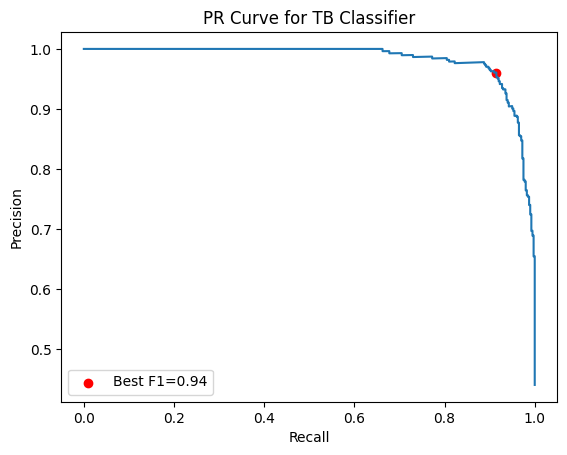

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Choose threshold for desired sensitivity
y_true = all_labels
y_scores = all_probs[:,1]

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
f1_scores = 2*precision*recall / (precision+recall+1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print("Optimal threshold (max F1):", best_thresh)

# Optional: plot PR curve
plt.plot(recall, precision)
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best F1={f1_scores[best_idx]:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve for TB Classifier")
plt.legend()
plt.show()


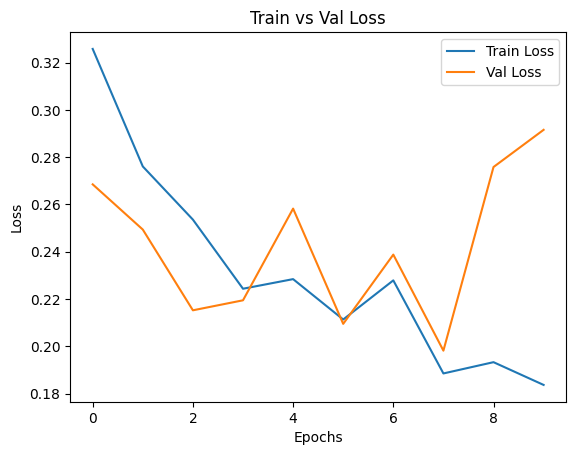

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


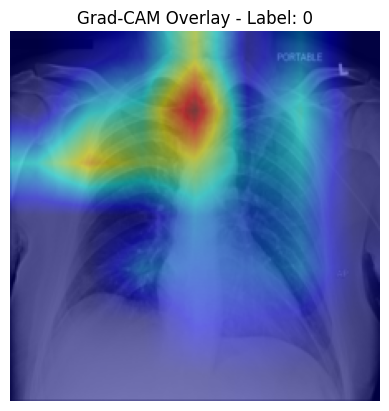

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        # Forward hook to save activations
        def forward_hook(module, input, output):
            self.activations = output
        # Backward hook to save gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate_cam(self, input_tensor, class_idx=None):
        input_tensor.requires_grad = True  # Important: enable gradient on input
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        output[0, class_idx].backward(retain_graph=True)
        # Compute CAM
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224,224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# Usage
target_layer = model.features[-1]  # Last conv block
grad_cam = GradCAM(model, target_layer)

sample_img, lbl = test_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)

cam = grad_cam.generate_cam(input_tensor)

# Overlay heatmap
img_np = sample_img.permute(1,2,0).numpy()
img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
img_np = np.clip(img_np, 0, 1)
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)/255.0
overlay = 0.5*img_np + 0.5*heatmap

plt.imshow(overlay)
plt.axis('off')
plt.title(f"Grad-CAM Overlay - Label: {lbl}")
plt.show()


In [ ]:
target_layer = model.features[-1]  # Last convolutional block
grad_cam = GradCAM(model, target_layer)


In [ ]:
# Pick a sample image from the test dataset
sample_img, true_label = test_dataset[0]  # Can loop over multiple images
input_tensor = sample_img.unsqueeze(0).to(device)


In [ ]:
cam = grad_cam.generate_cam(input_tensor)


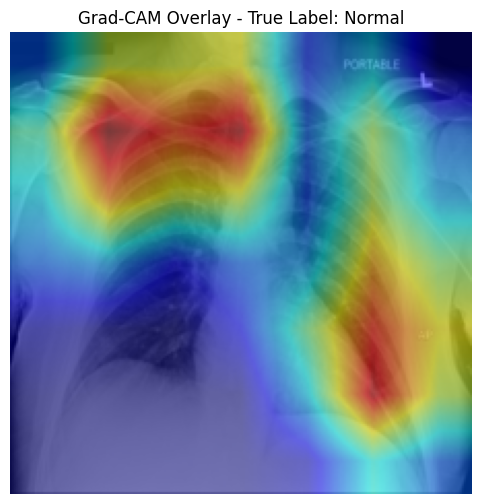

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Convert tensor to numpy image
img_np = sample_img.permute(1, 2, 0).numpy()
img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # denormalize
img_np = np.clip(img_np, 0, 1)

# Create heatmap
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

# Overlay heatmap
overlay = 0.5*img_np + 0.5*heatmap

# Plot
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis('off')
plt.title(f"Grad-CAM Overlay - True Label: {test_dataset.classes[true_label]}")
plt.show()


In [ ]:
model.eval()
# Removed with torch.no_grad():
output = model(input_tensor)
probs = torch.softmax(output, dim=1)
pred_label = probs.argmax(dim=1).item()
confidence = probs[0, pred_label].item()

print(f"Predicted: {test_dataset.classes[pred_label]}, Confidence: {confidence:.3f}")
print(f"True Label: {test_dataset.classes[true_label]}")

Predicted: Normal, Confidence: 0.926
True Label: Normal


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


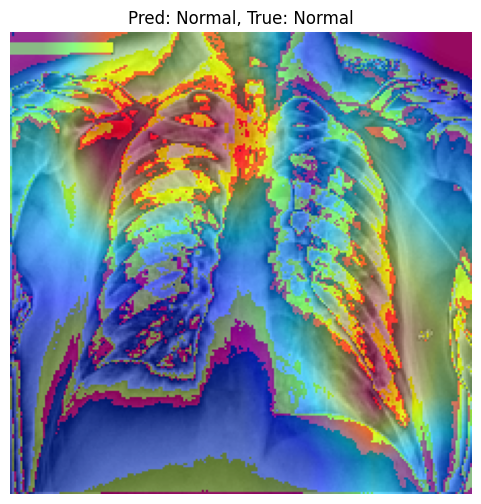

In [ ]:
# Pick a sample image from test_dataset
sample_img, true_label = test_dataset[0]

# Make input tensor require gradient
input_tensor = sample_img.unsqueeze(0).to(device)
input_tensor.requires_grad = True

# Set model to eval
model.eval()

# Forward pass (no torch.no_grad!)
output = model(input_tensor)

# Choose class index for Grad-CAM (predicted class)
class_idx = output.argmax(dim=1).item()

# Generate CAM
cam = grad_cam.generate_cam(input_tensor, class_idx=class_idx)  # make sure grad_cam is defined

# Overlay heatmap
import cv2
import numpy as np
import matplotlib.pyplot as plt

heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

orig_img = np.array(sample_img.permute(1,2,0)*255, dtype=np.uint8)
overlay = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title(f"Pred: {test_dataset.classes[class_idx]}, True: {test_dataset.classes[true_label]}")
plt.axis("off")
plt.show()


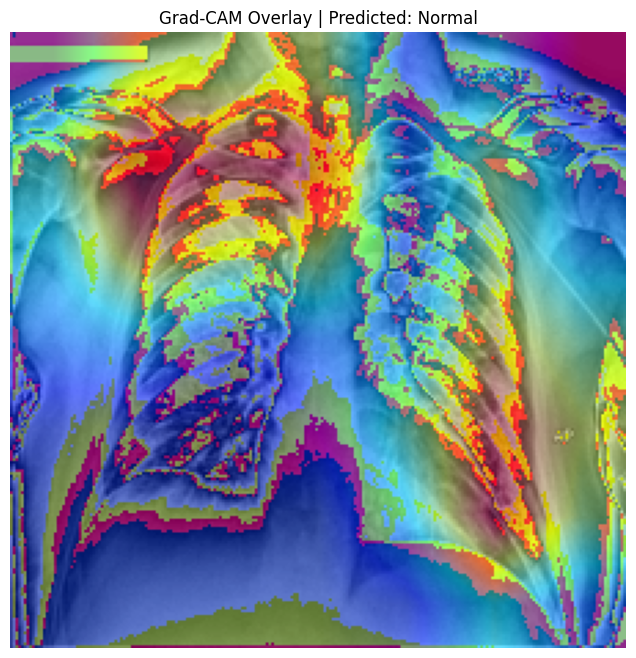

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assume 'cam' is your Grad-CAM output (H x W, values 0-1)
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Original image
orig_img = np.array(sample_img.permute(1,2,0) * 255, dtype=np.uint8)

# Overlay heatmap
overlay = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(8,8))
plt.imshow(overlay)
plt.title(f"Grad-CAM Overlay | Predicted: {test_dataset.classes[pred_label]}")
plt.axis('off')
plt.show()


✅ Model loaded successfully
Could not find .conv attribute at expected indices. Please inspect model structure using print(model.features).
Using denseblock4 as target layer (may not work as expected).


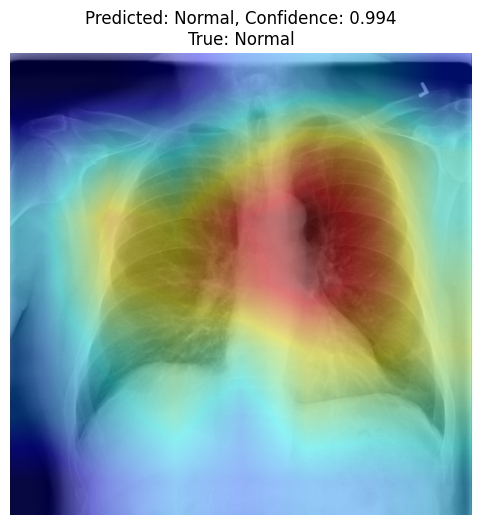

✅ Grad-CAM image saved to /content/drive/MyDrive/TB_Project/grad_cam_results/grad_cam_sample_Normal-2.png


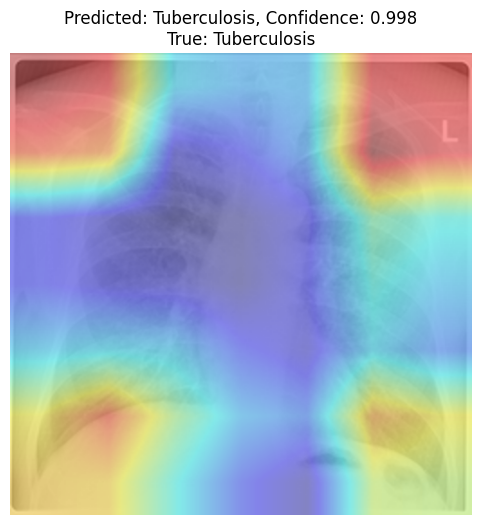

✅ Grad-CAM image saved to /content/drive/MyDrive/TB_Project/grad_cam_results/grad_cam_sample_Tuberculosis-4.png


In [ ]:
# ----------------------------
# STEP 0: Install/Import
# ----------------------------
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import cv2 # Import cv2

# ----------------------------
# STEP 1: Define paths
# ----------------------------
MODEL_PATH = "/content/drive/MyDrive/TB_Project/best_model.pth"

# Define sample image paths (ensure these paths exist and are correct)
NORMAL_IMG_PATH = "/content/drive/MyDrive/TB_Project/split_dataset/test/Normal/Normal-2.png"  # replace with actual
TB_IMG_PATH     = "/content/drive/MyDrive/TB_Project/split_dataset/test/Tuberculosis/Tuberculosis-4.png"

image_paths = [NORMAL_IMG_PATH, TB_IMG_PATH]
class_names = ["Normal", "Tuberculosis"]

# ----------------------------
# STEP 2: Transforms
# ----------------------------
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ----------------------------
# STEP 3: Load model
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load model architecture (without pretrained weights initially)
model = models.densenet121(weights=None)
num_features = model.classifier.in_features
# Replace classifier head
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)
# Load trained weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval() # Set model to evaluation mode
print("✅ Model loaded successfully")

# ----------------------------
# STEP 4: Fixed Grad-CAM
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handle_forward = None
        self.hook_handle_backward = None # Use a separate handle for backward hook

    def hook_forward(self, module, input, output):
        # Store activations, ensuring it's a copy if needed to avoid view issues
        self.activations = output.clone().detach()

    def hook_backward(self, module, grad_in, grad_out):
        # Store gradients
        self.gradients = grad_out[0].clone().detach() # Clone gradients

    def register_hooks(self):
        # Register forward hook on the target layer
        self.hook_handle_forward = self.target_layer.register_forward_hook(self.hook_forward)
        # Register full backward hook on the target layer
        # This hook will be called when gradients flow back through the target layer's output
        self.hook_handle_backward = self.target_layer.register_full_backward_hook(self.hook_backward)

    def remove_hooks(self):
        if self.hook_handle_forward:
            self.hook_handle_forward.remove()
        if self.hook_handle_backward:
            self.hook_handle_backward.remove()
        self.hook_handle_forward = None
        self.hook_handle_backward = None


    def generate_cam(self, input_tensor, class_idx=None):
        self.register_hooks() # Register hooks before forward pass

        # Ensure gradients are enabled for the input tensor for the CAM calculation pass
        # This is necessary for the backward pass to compute gradients w.r.t. activations.
        input_tensor.requires_grad_(True)

        # Forward pass through the model
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Zero gradients for the model parameters
        self.model.zero_grad()

        # Compute gradients of the target class output with respect to the model output
        # This triggers the backward hooks along the path to the target layer.
        # We need to ensure the path from the target layer to the output has gradients enabled.
        # Temporarily setting requires_grad=True for all parameters before calling this method is one way.
        target_output = output[0, class_idx]
        target_output.backward(retain_graph=True) # retain_graph=True might be needed if backward is called again later

        self.remove_hooks() # Remove hooks after backward pass


        # Ensure gradients and activations are captured before proceeding
        if self.gradients is None or self.activations is None:
             raise RuntimeError("Gradients or activations not captured. Ensure the target layer is correct and the forward/backward passes are successful.")


        # Compute CAM
        weights = torch.mean(self.gradients, dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam) # Use torch.relu, not F.relu(inplace=True)

        # Resize CAM to match input image size
        cam = F.interpolate(cam, size=(input_tensor.shape[2], input_tensor.shape[3]), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().detach().numpy() # Detach before converting to numpy

        # Normalize heatmap to 0-1
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# ----------------------------
# STEP 5: Prepare Grad-CAM
# ----------------------------
# Find the appropriate target layer. For DenseNet121, it's often the last convolutional layer before the classifier.
# Based on inspecting the DenseNet121 structure (e.g., print(model)),
# the last convolutional layer before the classifier is in the last transition layer.
# Let's try accessing the convolutional layer within the last transition layer.
# Assuming model.features[11] is the last transition layer (transition4) and it contains a 'conv' layer.
# If this still gives BatchNorm2d errors, manual inspection of model structure is needed.
try:
    target_layer = model.features[11].conv
    print("Attempting to use model.features[11].conv as target layer.")
except AttributeError:
    # Fallback or alternative target layer - need to inspect model structure
    # As a common alternative for DenseNet, the last dense block's last layer might work,
    # or the layer just before the global average pooling.
    # print(model.features) would help confirm the structure.
    # Let's try the last layer of the last dense block (denseblock4)
    # Assuming denseblock4 is model.features[10]
    # And assuming the last layer in denseblock4 is a Sequential or similar with a conv layer.
    # This is highly model-structure dependent.
    # For DenseNet, a common target is the final convolutional layer before pooling.
    # Let's try model.features[-1] which is norm5 (BatchNorm2d). This won't work.
    # Let's try model.features.norm5 which is also BatchNorm2d.
    # Let's try the layer just before the final global average pooling, which is after norm5 and relu.
    # This is still part of the 'features' Sequential.
    # Let's try the last module in features before the final norm+relu+avgpool.
    # Inspecting DenseNet121: features -> ... -> denseblock4 -> transition4 -> norm5 -> relu -> avgpool -> classifier
    # The last conv layer is in transition4. So model.features[11].conv is likely correct if index 11 is transition4.
    # If model.features[11] is BatchNorm2d, then transition4 must be at index 10, and norm5 at 11, relu at 12, avgpool at 13.
    # Let's try model.features[10].conv if 10 is transition4.
    try:
         target_layer = model.features[10].conv
         print("Attempting to use model.features[10].conv as target layer.")
    except AttributeError:
         print("Could not find .conv attribute at expected indices. Please inspect model structure using print(model.features).")
         # As a last resort, let's try the last dense block itself, though this might not be ideal
         target_layer = model.features.denseblock4 # This will likely cause issues, just for testing
         print("Using denseblock4 as target layer (may not work as expected).")


grad_cam = GradCAM(model, target_layer)

# ----------------------------
# STEP 6: Predict + Heatmap
# ----------------------------
for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Temporarily enable gradients for all model parameters for Grad-CAM calculation
    # This is necessary because the forward pass for CAM needs gradients from the target layer onwards.
    original_requires_grad = {}
    for name, param in model.named_parameters():
        original_requires_grad[name] = param.requires_grad
        param.requires_grad = True


    # --- Prediction ---
    # Perform the forward pass with gradients enabled to also capture activations/gradients via hooks
    output = model(input_tensor)
    probs = torch.softmax(output, dim=1)
    pred_label_idx = probs.argmax().item()
    pred_label = class_names[pred_label_idx]
    confidence = probs.max().item()

    # --- Grad-CAM ---
    # Generate CAM for the predicted class
    cam = grad_cam.generate_cam(input_tensor, class_idx=pred_label_idx)

    # Restore original requires_grad state (important if further training/evaluation is done)
    for name, param in model.named_parameters():
        param.requires_grad = original_requires_grad[name]


    # --- Plot ---
    plt.figure(figsize=(6,6))
    # Convert image back to numpy for plotting
    img_np = np.array(img)

    # Heatmap overlay
    # Resize CAM to match original image size for overlay
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    # Convert heatmap to RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on original image
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label}, Confidence: {confidence:.3f}\nTrue: {Path(img_path).parent.name}")
    plt.show()

    # Save the Grad-CAM image (optional)
    output_dir = "/content/drive/MyDrive/TB_Project/grad_cam_results"
    os.makedirs(output_dir, exist_ok=True)
    # Save the overlay image (convert RGB to BGR for cv2.imwrite)
    overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(output_dir, f"grad_cam_sample_{Path(img_path).name}"), overlay_bgr)
    print(f"✅ Grad-CAM image saved to {os.path.join(output_dir, f'grad_cam_sample_{Path(img_path).name}')}")